In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yasserh/breast-cancer-dataset")

print("Path to dataset files:", path)

100%|██████████| 48.6k/48.6k [00:00<00:00, 171kB/s]

Extracting model files...
Path to dataset files: C:\Users\OMEN\.cache\kagglehub\datasets\yasserh\breast-cancer-dataset\versions\1


In [2]:
# Setup: libs, style, config
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (7, 4)

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.decomposition import PCA
from sklearn.inspection import DecisionBoundaryDisplay

# Customized input for breast-cancer.csv
INPUT_CSV = r"C:\Users\OMEN\.cache\kagglehub\datasets\yasserh\breast-cancer-dataset\versions\1\breast-cancer.csv"  # adjust path if needed
RANDOM_STATE = 42
TEST_SIZE = 0.2

assert os.path.exists(INPUT_CSV), f"File not found: {INPUT_CSV}"


In [3]:
# Load breast cancer dataset
df = pd.read_csv(INPUT_CSV)

# Drop ID column if present
if "id" in df.columns:
    df = df.drop(columns=["id"])

# Target and features
assert "diagnosis" in df.columns, "Expected 'diagnosis' column not found."
y_raw = df["diagnosis"].astype(str)
X = df.drop(columns=["diagnosis"])

# Label-encode diagnosis: M=1 (malignant), B=0 (benign)
le = LabelEncoder()
y = le.fit_transform(y_raw)

print("Shape:", X.shape, "| Classes:", list(le.classes_), "| Positive rate:", np.mean(y).round(4))
display(df.head())


Shape: (569, 30) | Classes: ['B', 'M'] | Positive rate: 0.3726


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
print("Train/Test:", X_train.shape, X_test.shape)

# Standardize features (critical for SVM)
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)


Train/Test: (455, 30) (114, 30)


Linear SVM - Accuracy: 0.9649


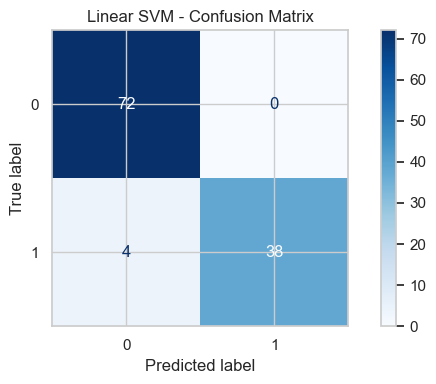

Linear SVM Classification Report:
              precision    recall  f1-score   support

           B       0.95      1.00      0.97        72
           M       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



In [5]:
# Train Linear SVM
svm_linear = SVC(kernel="linear", random_state=RANDOM_STATE)
svm_linear.fit(X_train_sc, y_train)

y_pred_lin = svm_linear.predict(X_test_sc)
acc_lin = accuracy_score(y_test, y_pred_lin)
print(f"Linear SVM - Accuracy: {acc_lin:.4f}")

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_lin)).plot(cmap="Blues", values_format="d")
plt.title("Linear SVM - Confusion Matrix")
plt.tight_layout()
plt.show()

print("Linear SVM Classification Report:")
print(classification_report(y_test, y_pred_lin, target_names=le.classes_))


RBF SVM - Accuracy: 0.9737


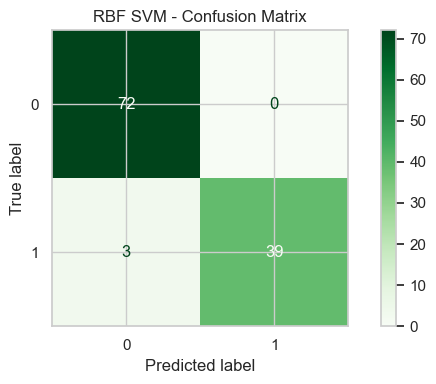

RBF SVM Classification Report:
              precision    recall  f1-score   support

           B       0.96      1.00      0.98        72
           M       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



In [6]:
# Train RBF SVM
svm_rbf = SVC(kernel="rbf", random_state=RANDOM_STATE)
svm_rbf.fit(X_train_sc, y_train)

y_pred_rbf = svm_rbf.predict(X_test_sc)
acc_rbf = accuracy_score(y_test, y_pred_rbf)
print(f"RBF SVM - Accuracy: {acc_rbf:.4f}")

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rbf)).plot(cmap="Greens", values_format="d")
plt.title("RBF SVM - Confusion Matrix")
plt.tight_layout()
plt.show()

print("RBF SVM Classification Report:")
print(classification_report(y_test, y_pred_rbf, target_names=le.classes_))


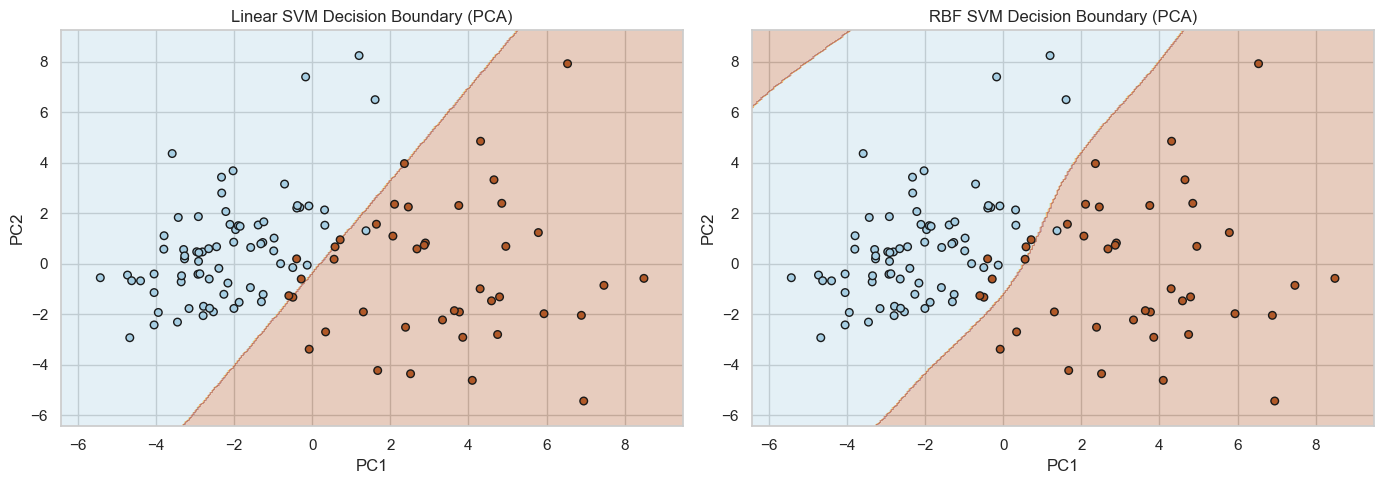

In [7]:
# Project to 2D for visualization
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_train_2d = pca.fit_transform(X_train_sc)
X_test_2d = pca.transform(X_test_sc)

# Train 2D models for visualization only
svm_lin_2d = SVC(kernel="linear", random_state=RANDOM_STATE)
svm_lin_2d.fit(X_train_2d, y_train)

svm_rbf_2d = SVC(kernel="rbf", random_state=RANDOM_STATE)
svm_rbf_2d.fit(X_train_2d, y_train)

# Plot decision boundaries
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, model, title in zip(axes, [svm_lin_2d, svm_rbf_2d], ["Linear SVM", "RBF SVM"]):
    DecisionBoundaryDisplay.from_estimator(
        model, X_test_2d, response_method="predict",
        cmap=plt.cm.Paired, alpha=0.3, ax=ax, grid_resolution=300
    )
    ax.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, edgecolor="k", cmap=plt.cm.Paired, s=30)
    ax.set_title(f"{title} Decision Boundary (PCA)")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

plt.tight_layout()
plt.show()


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best hyperparameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV accuracy: 0.9758241758241759
Best SVM Test Accuracy: 0.9737


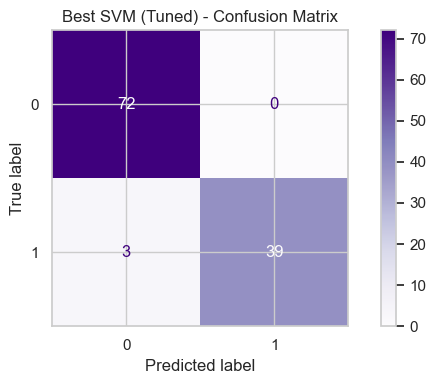

In [8]:
# GridSearchCV for C and gamma tuning on RBF kernel
param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1],
    "kernel": ["rbf"]
}

grid_search = GridSearchCV(
    SVC(random_state=RANDOM_STATE),
    param_grid,
    cv=5,
    scoring="accuracy",
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train_sc, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)

# Evaluate best model on test set
best_svm = grid_search.best_estimator_
y_pred_best = best_svm.predict(X_test_sc)
acc_best = accuracy_score(y_test, y_pred_best)
print(f"Best SVM Test Accuracy: {acc_best:.4f}")

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_best)).plot(cmap="Purples", values_format="d")
plt.title("Best SVM (Tuned) - Confusion Matrix")
plt.tight_layout()
plt.show()


In [9]:
# 5-fold stratified CV with best hyperparameters
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Full data (scaled)
X_all_sc = scaler.fit_transform(X)

cv_scores = cross_val_score(best_svm, X_all_sc, y, cv=cv, scoring="accuracy")
print(f"5-fold CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


5-fold CV Accuracy: 0.9754 ± 0.0195
